# importar librerias

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm

# crear modelo

In [19]:
class DQNNetwork(nn.Module):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim, initial_layer=128, medium_layer=128):
        print("initial_layer", initial_layer)
        print("medium layer", medium_layer)
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, initial_layer)
        self.fc2 = nn.Linear(initial_layer, medium_layer)
        self.fc3 = nn.Linear(medium_layer, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN entrenamiento 

In [13]:
class DQNAgent:
    def __init__(
        self,
        env_name="MountainCar-v0",
        episodes=1000,
        gamma=0.9,
        lr=0.0005,
        batch_size=64,
        n_bins=30,
        initial_layer=128,
        medium_layer=128,
        
    ):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=10000)  # Memoria de experiencia
        self.rewards_per_episode = []
        self.best_reward = -np.inf
        self.best_rewards_per_episode = []
        self.losses = []
        self.epsilon_values = []
        self.initial_layer=initial_layer
        self.medium_layer=medium_layer

        # Discretización del espacio de estados
        self.n_bins = n_bins  # Número de bins para discretizar
        self.pos_space = np.linspace(
            self.env.observation_space.low[0],
            self.env.observation_space.high[0],
            n_bins,
        )
        self.vel_space = np.linspace(
            self.env.observation_space.low[1],
            self.env.observation_space.high[1],
            n_bins,
        )

        # Dimensiones de entrada y salida
        self.input_dim = (
            2  # Dos características: posición y velocidad (después de discretización)
        )
        self.output_dim = self.env.action_space.n  # Tres acciones posibles

        # Inicialización de la red y la red objetivo
        self.network = DQNNetwork(self.input_dim, self.output_dim, self.initial_layer,self.medium_layer)
        self.target_network = DQNNetwork(self.input_dim, self.output_dim, self.initial_layer, self.medium_layer)
        self.target_network.load_state_dict(
            self.network.state_dict()
        )  # Copiar pesos de la red actual
        self.target_network.eval()  # Poner la red objetivo en modo evaluación

        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def discretize_state(self, state):
        """Discretiza el estado (posición y velocidad) en índices"""
        pos, vel = state
        pos_index = np.digitize(pos, self.pos_space) - 1
        vel_index = np.digitize(vel, self.vel_space) - 1
        return pos_index, vel_index

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar la transición en la memoria de experiencia"""
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria"""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción usando la política epsilon-greedy"""
        pos_index, vel_index = self.discretize_state(state)
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Acción aleatoria
        state_tensor = torch.tensor(
            [pos_index, vel_index], dtype=torch.float32
        ).unsqueeze(0)
        with torch.no_grad():
            q_values = self.network(state_tensor)
        return torch.argmax(q_values).item()  # Acción con el Q-valor más alto

    def update_network(self):
        """Actualizar los pesos de la red usando el algoritmo DQN"""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(
            [self.discretize_state(state) for state in states], dtype=torch.float32
        )
        next_states = torch.tensor(
            [self.discretize_state(state) for state in next_states], dtype=torch.float32
        )
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Predicción Q(s, a) con la red actual
        q_values = self.network(states).gather(1, actions.unsqueeze(1))

        # Predicción Q(s', a') con la red objetivo
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards.unsqueeze(1) + (
            self.gamma * next_q_values * (1 - dones.unsqueeze(1))
        )

        # Calculamos la pérdida
        loss = self.loss_fn(q_values, target_q_values)

        # Actualizamos los pesos de la red
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item())
        return loss.item()

    def update_target_network(self):
        """Actualizar la red objetivo con los pesos de la red actual"""
        self.target_network.load_state_dict(self.network.state_dict())

    def save_model(self):
        """Guardar el modelo entrenado"""
        torch.save(self.network.state_dict(), "mountaincar_dqn_model.pth")

    def train(self):
        """Entrenamiento del agente"""
        for episode in  tqdm( range(1, self.episodes + 1)):
            state, _ = self.env.reset()
            total_reward = 0
            terminated = False
            truncated = False

            while not terminated and not truncated:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, terminated)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(
                self.best_reward
            )  # Almacenar la mejor recompensa
            self.epsilon = max(self.epsilon - self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)

            # Actualización de la red objetivo cada 10 episodios
            if episode % 5 == 0:
                self.update_target_network()

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()  # Guardar el modelo

            # Imprimir métricas cada 100 episodios
            # if episode % 100 == 0:
            #     mean_reward = np.mean(self.rewards_per_episode[-100:])
            #     print(
            #         f"Episodio {episode}/{self.episodes}, Recompensa: {total_reward:.2f}, Epsilon: {self.epsilon:.2f}, "
            #         f"Best Reward: {self.best_reward:.2f}, Mean Reward: {mean_reward:.2f}"
            #     )

        self.plot_rewards()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas y métricas del entrenamiento"""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on MountainCar")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Loss per Update", color="red")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay During Training")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        # Promedio móvil para suavizar la curva de mejores recompensas
        window_size = 50
        best_rewards_smooth = np.convolve(
            self.best_rewards_per_episode,
            np.ones(window_size) / window_size,
            mode="valid",
        )

        plt.plot(best_rewards_smooth, label="Smoothed Best Reward", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Smoothed Best Reward")
        plt.title("Smoothed Best Reward Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()


# llamar entrenamiento


initial_layer= 128

medium layer=128

initial_layer 128
medium layer 128
initial_layer 128
medium layer 128


100%|██████████| 500/500 [13:14<00:00,  1.59s/it]


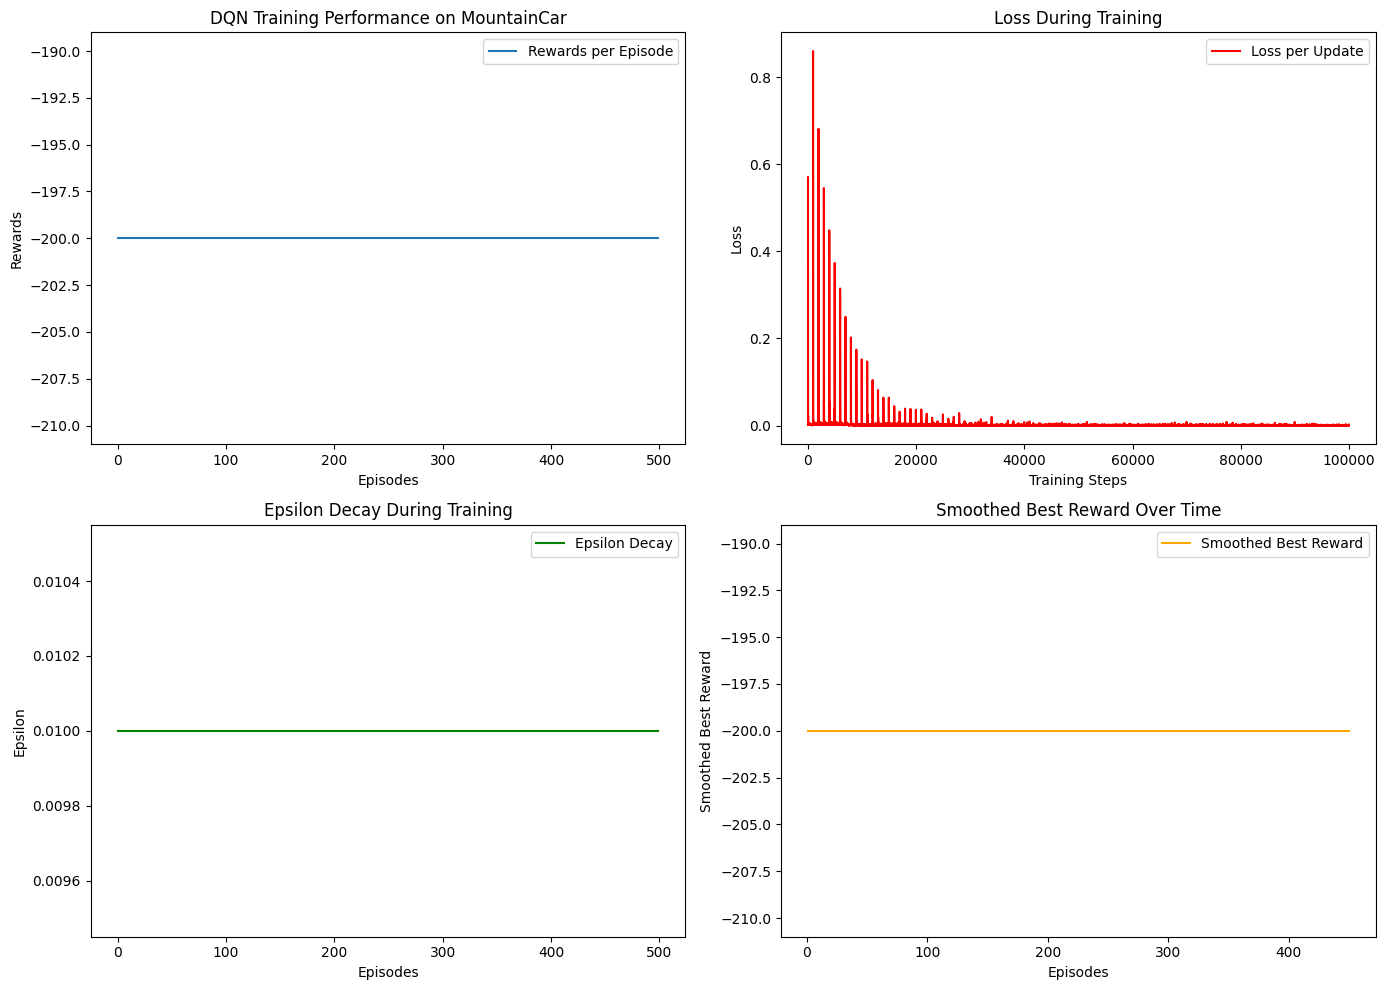

In [9]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500)
    agent.train()

initial_layer= 64

medium layer=64

initial_layer 64
medium layer 64
initial_layer 64
medium layer 64


100%|██████████| 500/500 [12:16<00:00,  1.47s/it]


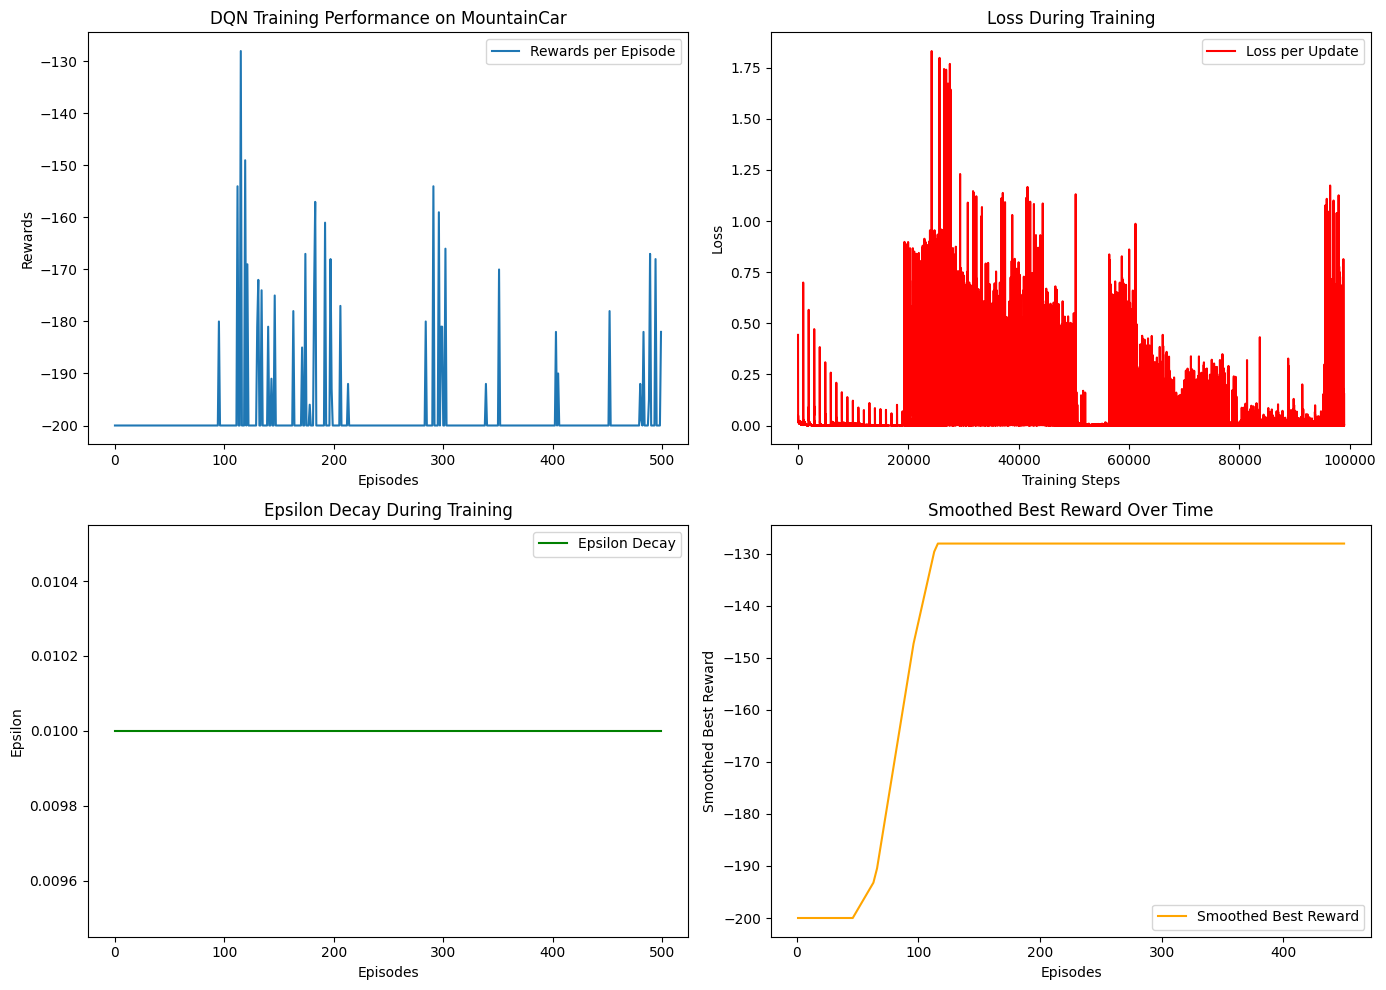

In [14]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500, initial_layer=64, medium_layer=64)
    agent.train()

initial_layer= 128

medium layer= 64

initial_layer 128
medium layer 64
initial_layer 128
medium layer 64


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [12:55<00:00,  1.55s/it]


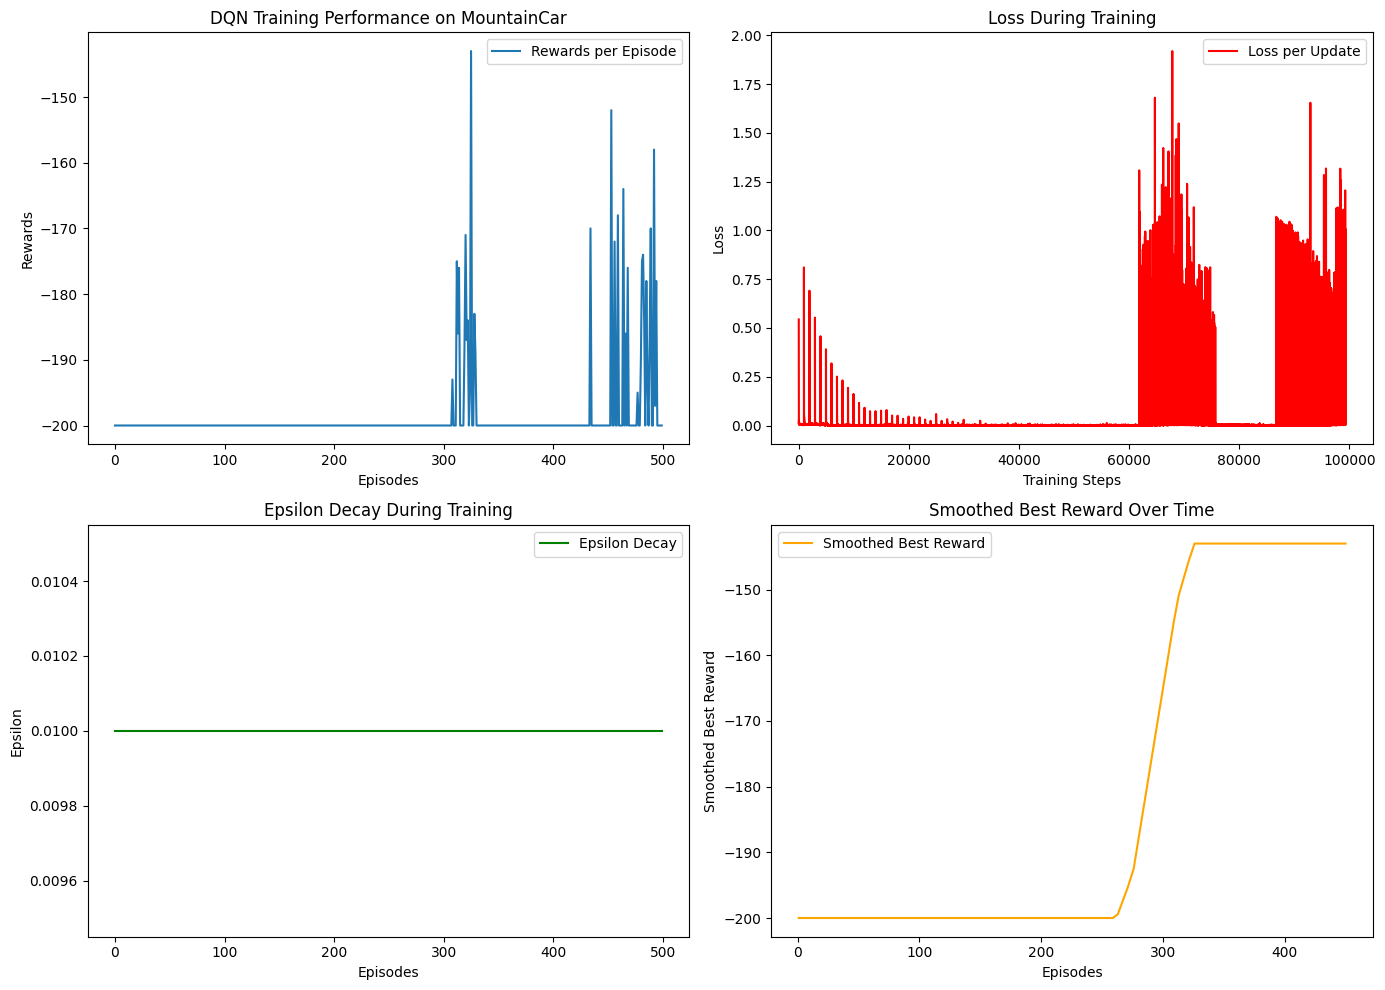

In [20]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500, initial_layer=128, medium_layer=64)
    agent.train()

initial_layer= 64

medium layer=128

initial_layer 64
medium layer 128
initial_layer 64
medium layer 128


100%|██████████| 500/500 [12:37<00:00,  1.51s/it]


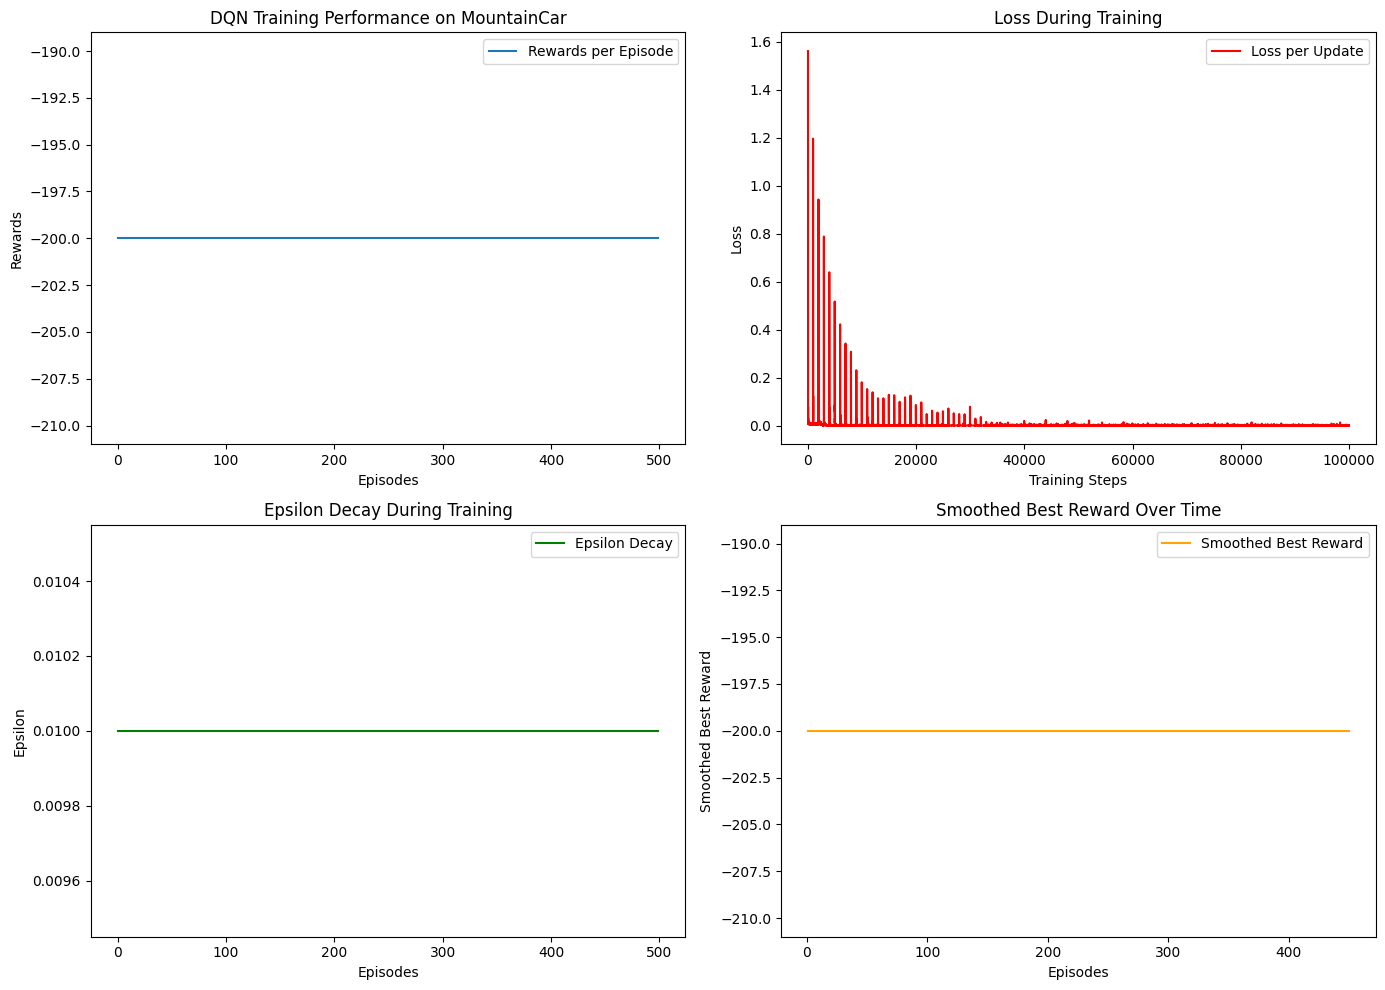

In [21]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500, initial_layer=64, medium_layer=128)
    agent.train()

initial_layer= 256

medium layer=256

initial_layer 256
medium layer 256
initial_layer 256
medium layer 256


100%|██████████| 500/500 [14:47<00:00,  1.77s/it]


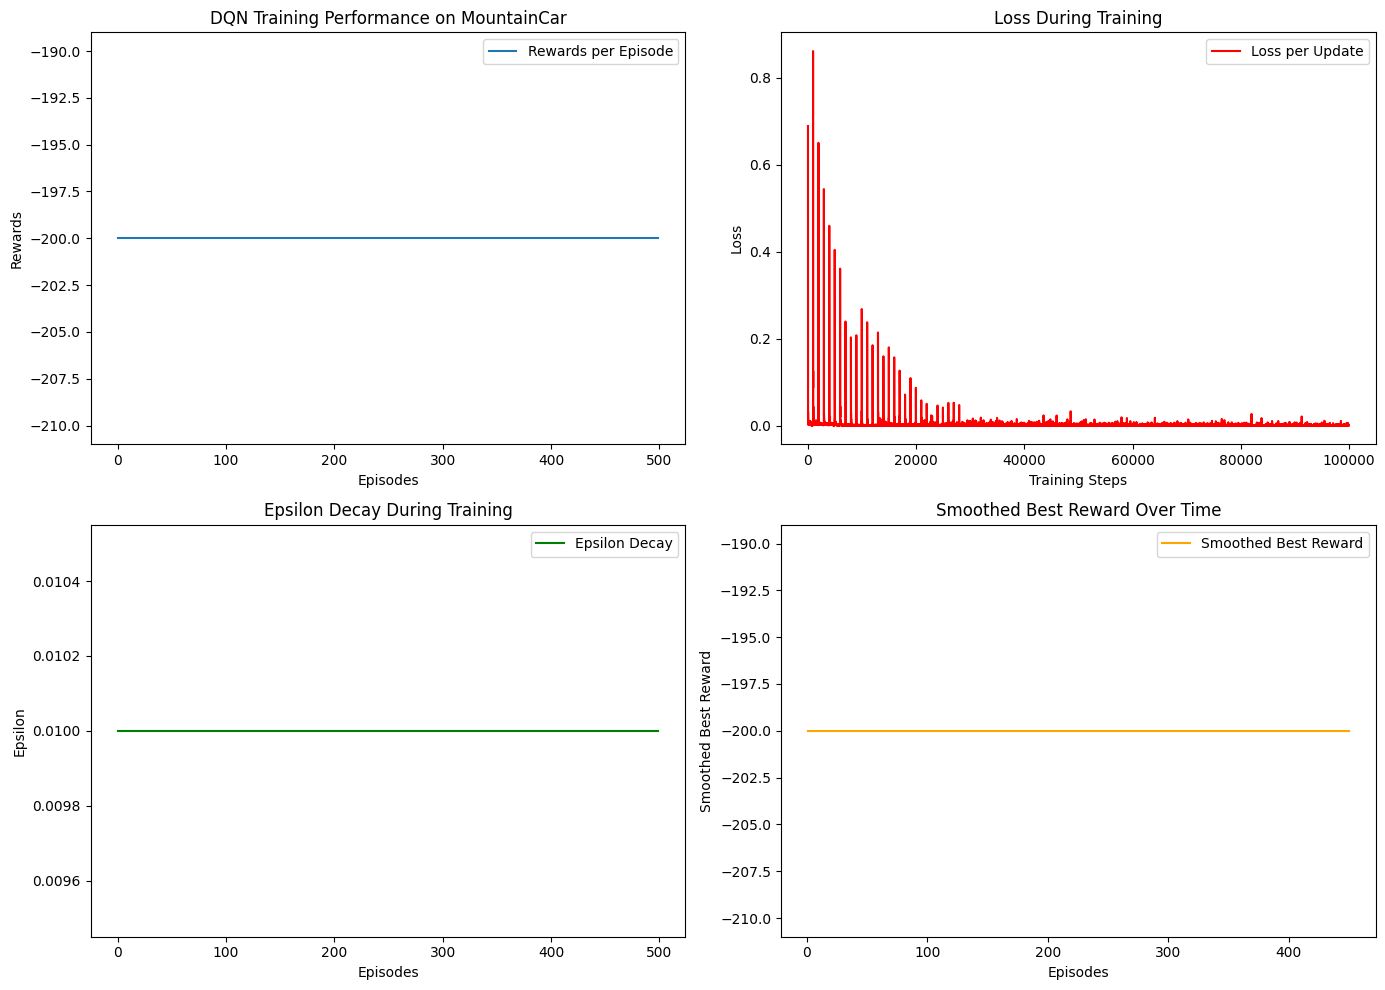

In [18]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500, initial_layer=256, medium_layer=256)
    agent.train()

initial_layer 64
medium layer 64
initial_layer 64
medium layer 64


100%|██████████| 1000/1000 [26:44<00:00,  1.60s/it]


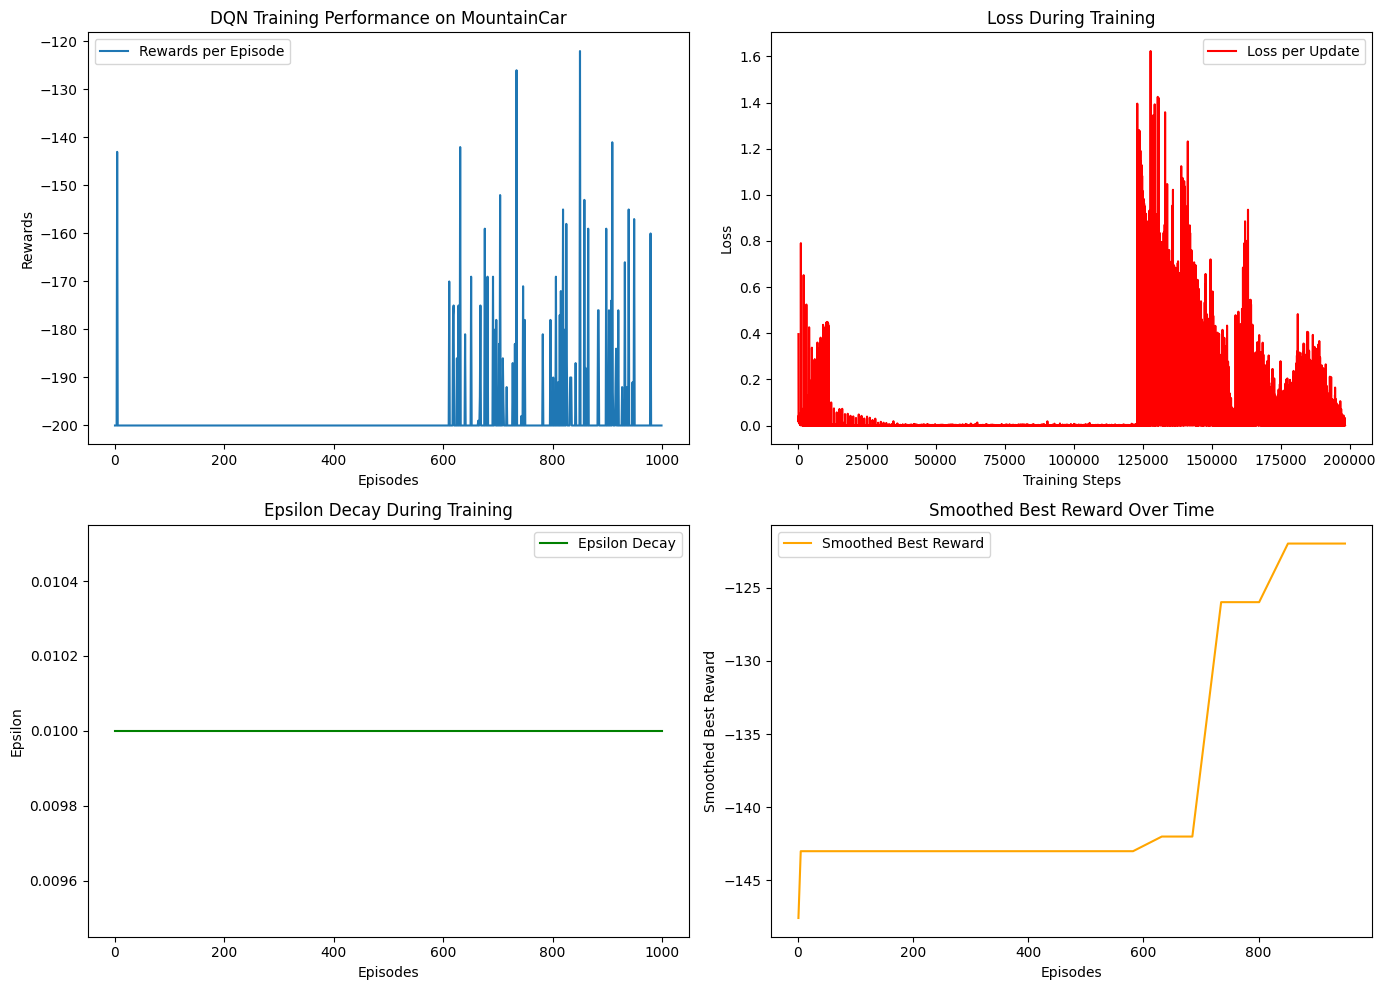

In [22]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=1000, initial_layer=64, medium_layer=64)
    agent.train()

# tensor

2024-12-16 21:53:11.883764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 21:53:11.886881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 21:53:11.894451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734403991.913684 2947026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734403991.918383 2947026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 21:53:11.934950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Episode: 1, Epsilon: 0.99, Best Reward: -9977.0, Mean Reward: -9977.0
Episode: 2, Epsilon: 0.99, Best Reward: -9977.0, Mean Reward: -52118.5
Episode: 3, Epsilon: 0.99, Best Reward: -9977.0, Mean Reward: -53736.7
Episode: 4, Epsilon: 0.98, Best Reward: -9977.0, Mean Reward: -55508.5
Episode: 5, Epsilon: 0.98, Best Reward: -9977.0, Mean Reward: -46735.6
Episode: 6, Epsilon: 0.97, Best Reward: -9977.0, Mean Reward: -49837.3
Episode: 7, Epsilon: 0.97, Best Reward: -9977.0, Mean Reward: -47435.1
Episode: 8, Epsilon: 0.96, Best Reward: -3610.0, Mean Reward: -41957.0
Episode: 9, Epsilon: 0.96, Best Reward: -3610.0, Mean Reward: -37810.9
Episode: 10, Epsilon: 0.95, Best Reward: -3610.0, Mean Reward: -38384.0


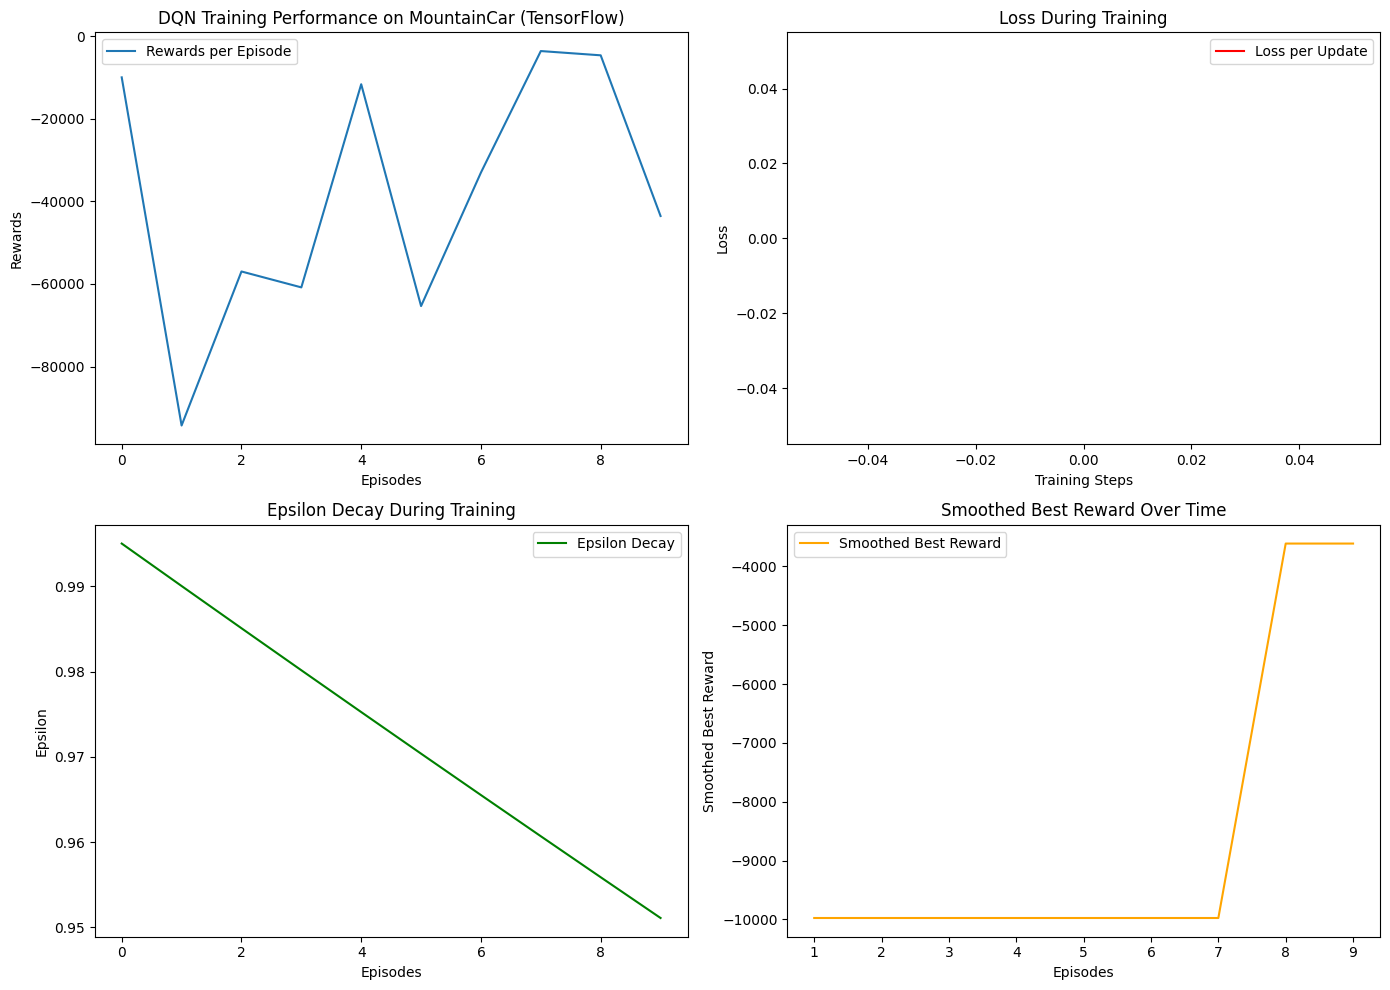

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class DQNNetworkTensor(tf.keras.Model):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim):
        super(DQNNetworkTensor, self).__init__()
        self.fc1 = layers.Dense(128, activation="relu", input_dim=input_dim)
        self.fc2 = layers.Dense(128, activation="relu")
        self.fc3 = layers.Dense(output_dim)  # Salida con una neurona por acción

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)  # Predicción Q-value por acción


class DQNAgentTensor:
    def __init__(
        self,
        env_name="MountainCar-v0",
        episodes=1000,
        gamma=0.9,
        lr=0.0005,
        n_bins=20,
        epsilon=1.0,
        epsilon_min=0.005,
    ):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 32
        self.replay_buffer_capacity = 5000

        self.rewards_per_episode = []
        self.best_reward = -np.inf
        self.losses = []  # Pérdidas
        self.epsilon_values = []  # Epsilon decay
        self.best_rewards_per_episode = []  # Mejores recompensas

        # Parámetros de discretización (Q-Learning)
        self.pos_space = np.linspace(
            self.env.observation_space.low[0],
            self.env.observation_space.high[0],
            n_bins,
        )
        self.vel_space = np.linspace(
            self.env.observation_space.low[1],
            self.env.observation_space.high[1],
            n_bins,
        )

        # Inicialización de la red neuronal
        input_dim = self.env.observation_space.shape[0]
        output_dim = (
            self.env.action_space.n
        )  # Tres acciones posibles (izquierda, derecha, ninguna acción)

        self.network = DQNNetworkTensor(input_dim, output_dim)
        self.target_network = DQNNetworkTensor(input_dim, output_dim)

        # Pasar un dummy input para inicializar los pesos
        self.network(np.zeros((1, input_dim)))
        self.target_network(np.zeros((1, input_dim)))

        # Copiar los pesos de la red principal a la red objetivo
        self.target_network.set_weights(self.network.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()  # Acción aleatoria (exploración)
        state = np.array(state).reshape(1, -1)  # Necesitamos la forma (1, input_dim)
        q_values = self.network(state, training=False)  # Predicción de Q-values
        return np.argmax(q_values[0])  # Seleccionar la acción con el mayor valor Q

    @tf.function
    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        # Discretizamos los estados antes de pasarlos a la red
        states = np.array([self.discretize_state(state) for state in states])
        next_states = np.array(
            [self.discretize_state(next_state) for next_state in next_states]
        )

        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones).astype(float)

        with tf.GradientTape() as tape:
            # Predicciones de Q para los estados actuales
            q_values = self.network(states)
            # Predicción de Q para los estados futuros (red objetivo)
            next_q_values = self.target_network(next_states)
            max_next_q_values = np.max(next_q_values, axis=1)

            # Cálculo de la recompensa esperada
            expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Seleccionar las Q-values correspondientes a las acciones tomadas
            q_values_taken = np.sum(
                q_values * tf.one_hot(actions, self.env.action_space.n), axis=1
            )

            # Calcular la pérdida
            loss = self.loss_fn(expected_q_values, q_values_taken)

        # Aplicar el gradiente
        grads = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

        # Registrar la pérdida
        self.losses.append(loss.numpy())

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(self.best_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)

            # Actualizar la red objetivo periódicamente
            if episode % 2 == 0:
                self.target_network.set_weights(self.network.get_weights())

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Imprimir métricas cada episodios
            mean_reward = np.mean(self.rewards_per_episode[-100:])
            print(
                f"Episode: {episode}, Epsilon: {self.epsilon:.2f}, "
                f"Best Reward: {self.best_reward:.1f}, Mean Reward: {mean_reward:.1f}"
            )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        self.network.save("mountaincar_dqn_model_tensor.keras")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network = keras.models.load_model("mountaincar_dqn_model_tensor.keras")
        self.update_target_network()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas y métricas del entrenamiento."""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on MountainCar (TensorFlow)")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Loss per Update", color="red")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay During Training")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        plt.plot(
            self.best_rewards_per_episode, label="Smoothed Best Reward", color="orange"
        )
        plt.xlabel("Episodes")
        plt.ylabel("Smoothed Best Reward")
        plt.title("Smoothed Best Reward Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    agent = DQNAgentTensor(episodes=10)
    agent.train()
